# Enova EMS_Beregningskjerne (Brukerhistorie)
Nima Darabi - Webstep - July - September 2021


In [12]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import re
import pydot as pd

def writechildren (s):
    for tuple in dependency_graph:
        if s ==tuple[0]:
            a.append(tuple)
            if not tuple[1].isnumeric():
                writechildren (tuple[1])

In [13]:
# Extract all relations
filename = "/Users/nimadarabi/Desktop/Projects/Enova/Energimerkeordningen/EnergiBeregning.py"
with open(filename) as file:
    lines = file.readlines()
    lines = [line.rstrip() for line in lines]

dependency_graph = []

allterminals = set([])
allnonterminals = set([])
alllines = set([])
keywords = ['log','max','mean','nan', 'np','self', 'pi', 'sum', 'else', 'exp', 'if']

namedict = {}
reldict = {}
for line in lines:
    if line.find("=") > -1:
        line = line.strip()
        index1 = line.find("=")
        after = line[index1+1: ]
        cell = line[0 : index1-1]
        if cell.find("#") == -1:
            index2 = after.find("#")
            formula = after[0:index2] if index2 > -1 else after[0:]
            description = after[index2+1 : ]
            namedict[cell] = description
            nonterminal_pattern = '[A-Z]+[0-9]+'
            terminal_pattern = '[a-zA-Z]+[a-zA-Z_0-9]*'

            nonterminals = re.findall(nonterminal_pattern, formula)
            terminals = re.findall(terminal_pattern, formula)
            terminals = list(set(terminals) - set(keywords))
            #re.findall('[a-zA-Z]+[a-zA-Z_0-9]*', ' self.energibehov_tappevann  ')

            allterminals    = allterminals   .union(set(terminals))
            allnonterminals = allnonterminals.union(set(nonterminals))
            alllines = alllines.union(set([line]))

            nextcells = nonterminals + terminals
            for destination in nextcells:
                if cell != destination:
                    dependency_graph.append((cell, destination, line))
                    
dependency_graph = list(set(dependency_graph))

print (len(dependency_graph))

2041


111


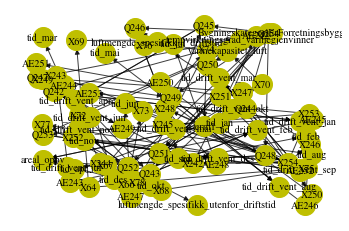

In [14]:
# Extract the calculation of a given cell
a = []
writechildren ('X64') # C20 C22 C49 term49 X64 Q254
print (len(a))

# Construct the graph
edges = [(i[0],i[1],1) for i in a]
if 0: print(*edges, sep='\n')
G=nx.DiGraph()
G.add_weighted_edges_from(edges)

# Layout
#pos = pd.graphviz_layout(T, prog="twopi")
pos=nx.circular_layout(G)  
pos=nx.random_layout(G) 
#pos=nx.spring_layout(G) 
#pos=nx.spectral_layout(G) 

nx.draw_networkx_nodes(G,pos,node_size=400, node_color='y')

# plot edges
nx.draw_networkx_edges(G,pos,edgelist=a,width=1,alpha=0.75,edge_color='k',style='solid') #dotted

# save graph
nx.draw_networkx_labels(G,pos,font_size=10,font_family='Times')
plt.axis('off')
plt.savefig("/Users/nimadarabi/Desktop/brukerhistorie.png", dpi=300) # save as png
plt.show() 

In [15]:
# https://observablehq.com/@d3/force-directed-graph